<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 直線フィッティング

誤差分布は外れ値が大きいコーシー分布

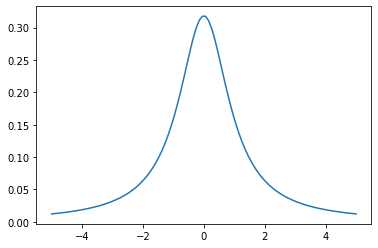

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def cauchy(x: np.ndarray):
    return 1/np.pi/(1+x*x)

x = np.linspace(-5, 5, 100)
y = cauchy(x)

plt.plot(x, y)
plt.show()

サンプルデータ生成

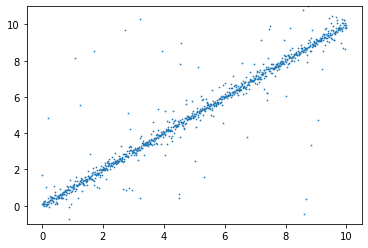

In [2]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

iteration の回数の目安は以下の通り：

1. データ分布から、1回のサンプリングで inlier を引き当てる確率 $e$ を仮定
2. 1回の試行でのサンプル数を $n$ とすると、それらのサンプルが全て inlier である確率は $e^n$
3. 一方で$N$回の試行で 2. が1回も生じない場合(RANSAC が失敗する場合)の確率は$(1-e^n)^N$
4. つまり RANSAC をほぼ確実(確率$p\sim1$)で成功させたい場合は
\begin{equation}
1-p=(1-e^n)^N⇔N=\frac{\ln(1-p)}{\ln(1-e^n)}
\end{equation}
くらいの$N$に設定して反復する。
4. 更に早期終了を目指す場合は、最大の inlier 数更新のタイミングで $e\sim$  (inlier とした数)/(データ数) として$N$を更新

In [3]:
# データの目視確認より 9/10 は対象データと想定
e = 9/10
# 直線のパラメータは2個 → サンプリング数は2個で十分
n = 2
# 99.99% の確率で RANSAC を成功させる
p = 0.9999
# zero division error 対策
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

5


乱数生成

In [4]:
index_mat = np.random.randint(0, point_num, (max_iteration, 2))
print(index_mat)

[[604 920]
 [713 829]
 [177 886]
 [867 466]
 [181 381]]


ランダムサンプリング

In [5]:
np.array([x[index_mat], y[index_mat]]).shape

(2, 5, 2)

In [6]:
# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)

print(samples_tensor.shape)
print(samples_tensor)

(5, 2, 2)
[[[6.04604605 6.0510086 ]
  [9.20920921 9.36355584]]

 [[7.13713714 7.37307136]
  [8.2982983  8.39533918]]

 [[1.77177177 2.13415969]
  [8.86886887 8.77025395]]

 [[8.67867868 0.3615291 ]
  [4.66466466 4.22848197]]

 [[1.81181181 1.7901481 ]
  [3.81381381 3.73425986]]]


傾きと切片計算

In [7]:
params_tensor = np.array([np.polyfit(sample[:, 0], sample[:, 1], 1) 
                          for sample in samples_tensor])

inlier の数を計算 → 最も良い候補を選択

In [8]:
def polynomial(params, points):
    max_degree = len(params)
    # shape=(params, points)
    terms = np.array([params[degree] * points[:, 0] ** (max_degree - degree - 1)
                      for degree in range(max_degree)])
    return np.sum(terms, axis=0)

def get_distances(params, points):
    y_est = polynomial(params, points)
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

0


結果を確認

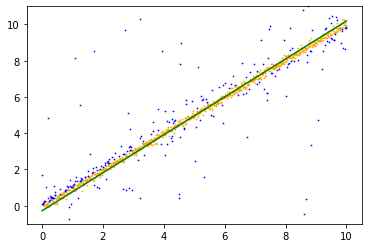

In [9]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(params, points),
         color="green")
plt.ylim(-1, 11)
plt.show()

再フィッティング

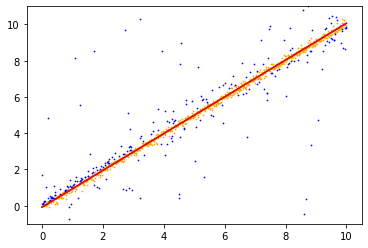

In [10]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 1)

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.ylim(-1, 11)
plt.show()

## 2次曲線フィッティング

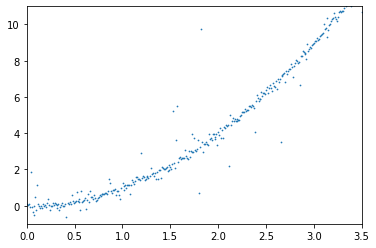

In [11]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x**2 + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

In [12]:
e = 6/10
n = 3
p = 0.9999
max_iteration = int(np.log(1-p)/_) if not np.isclose((_ := np.log(1-e**n)), 0) else 1e+5

print(max_iteration)

37


In [13]:
index_mat = np.random.randint(0, point_num, (max_iteration, 3))

# 転置前の成分数は (axis, trials, points)
# 転置後の成分数は (trials, points, axis)
samples_tensor = np.array([x[index_mat], y[index_mat]]).transpose(1, 2, 0)
print(samples_tensor.shape)

(37, 3, 2)


In [14]:
params_tensor = np.array([
    np.polyfit(sample[:, 0], sample[:, 1], 2)
    for sample in samples_tensor])

In [15]:
def get_distances(params, points):
    y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
    distances = np.abs(points[:, 1] - y_est)
    return distances

distances_tensor = np.array([
    get_distances(params, points) for params in params_tensor])

distance_th = 0.3
inlier_bool_tensor = np.array([
    distances < distance_th
    for distances in distances_tensor
])
inlier_num_array = np.array([
    np.sum(inlier_bool)
    for inlier_bool in inlier_bool_tensor
])

best_idx = np.argmax(inlier_num_array)
print(best_idx)

30


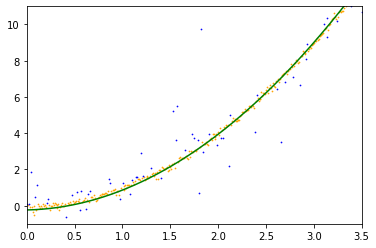

In [16]:
params = params_tensor[best_idx]
inlier_idx = np.arange(point_num)[inlier_bool_tensor[best_idx]]
outlier_idx = np.arange(point_num)[~inlier_bool_tensor[best_idx]]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")

y_est =  params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]
plt.plot(points[:, 0], y_est, color="green")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

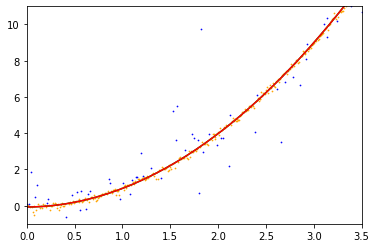

In [17]:
refined_params = np.polyfit(points[inlier_idx, 0], points[inlier_idx, 1], 2)
y_refined =  refined_params[0] * points[:, 0] **2 + params[1] * points[:, 0] + params[2]

plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")
plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")


plt.plot(points[:, 0], polynomial(refined_params, points), color="green")
plt.plot(points[:, 0], polynomial(refined_params, points), color="red")
plt.xlim(0, 3.5)
plt.ylim(-1, 11)
plt.show()

## 陰関数フィッティング

### RANSAC クラスの作成

自動微分を実施するための Jet を定義

In [18]:
class Jet:
    def __init__(self, a: float, v):
        self.a = a
        self.v = np.array(v)

    def __str__(self):
        return f"{self.a}+{self.v}"

    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a + other.a, self.v + other.v)

    def __sub__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeors(len(self.v)))
        return Jet(self.a - other.a, self.v - other.v)
    
    def __mul__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a * other.a, self.a * other.v + self.v * other.a)
    
    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        return Jet(self.a / other.a, self.v / other.a - self.a * other.v / other.a ** 2)
    
    def __pow__(self, other):
        if isinstance(other, (int, float)):
            other = Jet(other, np.zeros(len(self.v)))
        value = self.a ** other.a
        base_diff = other.a * self.a ** (other.a - 1) * self.v
        # 底が0, 負の場合に注意
        if np.isclose(self.a, 0):
            exp_diff = 0
        else:
            exp_diff = value * other.v * np.log(np.abs(self.a))
        return Jet(value, base_diff + exp_diff)

    def __radd__(self, other):
        return self.__add__(other)
    
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __rmul__(self, other):
        return self.__mul__(other)

x = Jet(2, (3, 4))
print(x.a)
print(x.v)

2
[3 4]


基底関数を定義

In [19]:
def linear_basis(point):
    x, y = point
    return [x, y, 1]

def quad_basis(point):
    x, y = point
    return [x**2, 2*x*y, y**2, 2*x, 2*y, 1]

x = Jet(1, (1, 0))
y = Jet(2, (0, 1))
print(quad_basis((x, y))[1])

4+[4. 2.]


陰関数プロットのためのヘルパー関数を定義

In [20]:
def get_contour(basis_func, points, params, diff):
    x_range=np.arange(np.min(points[:, 0]), np.max(points[:, 0]), diff)
    y_range=np.arange(np.min(points[:, 1]), np.max(points[:, 1]), diff)
    x_mesh, y_mesh=np.meshgrid(x_range, y_range)

    basises = basis_func((x_mesh, y_mesh))
    z_mesh=sum([param*basis for param, basis in zip(params, basises)])
    return x_mesh, y_mesh, z_mesh

前セクションまでの処理を踏まえて、RANSAC を行うための一般的なクラスを定義する

In [21]:
from typing import List
import numpy.linalg as LA
from tqdm import tqdm

class RANSAC:
    def __init__(self, basis_func, target_prob=0.9999):
        # 関数: データ点 -> List[基底関数]
        self.basis_func = basis_func
        # RANSAC の目標成功確率
        self.target_prob = target_prob

    def fit(self, points):
        xi_list = np.array([self.basis_func(point) for point in points])
        mat_list = np.array([np.outer(xi, xi) for xi in xi_list])

        e_value, e_vec = LA.eig(np.sum(mat_list, axis=0))
        # 非負定値行列の固有値のため abs を取る必要はない
        idx = np.argmin(e_value)
        return e_vec[idx]

    def jet_basis(self, point: np.ndarray) -> List[Jet]:
        """Jet 型の基底関数

        :param point: データ値(規格化済)
        :return:
        """
        jets = [Jet(point[idx], np.eye(len(point))[idx])
                for idx in range(len(point))]
        basis_list = self.basis_func(jets)
        return [basis + Jet(0, np.zeros_like(point)) for basis in basis_list]

    def get_cov_mat(self, point: np.ndarray) -> np.ndarray:
        """正規化共分散行列

        :param point: データ値(規格化済)
        :return: 正規化共分散行列
        """
        xi = self.jet_basis(point)
        return np.array([[np.dot(xi[i].v, xi[j].v) for j in range(len(xi))] 
                         for i in range(len(xi))])
        
    def sampson_error(self, point: np.ndarray, params: np.ndarray):
        cov_mat = self.get_cov_mat(point)
        denominator = np.dot(params, cov_mat @ params)

        xi = self.basis_func(point)
        numerator = np.dot(xi, params) ** 2

        return numerator/denominator if not np.isclose(denominator, 0) else np.inf

    def criteria(self, inlier_prob: float, degree: int) -> int:
        """RANSAC の終了条件を計算

        :param inlier_prob: inlier の割合/確率
        :param degree: フィッティング次数/サンプル数
        :return: RANSAC の反復回数の目安
        """
        # zero division error 対策
        return int(np.log(1-self.target_prob)/_) \
            if not np.isclose((_ := np.log(1-inlier_prob**degree)), 0) else 1e+5

    def execute(self, points, distance_th=0.1):
        data_num = points.shape[0]
        # パラメータは規格化するのでその拘束条件で -1
        degree = len(self.basis_func(points[0, :]))-1
        # 最悪のケースとして inlier がデータの 1/10 と仮定
        inlier_prob = 0.1
        max_iteration = self.criteria(inlier_prob, degree)

        iteration=0
        best_inlier_bool = [False for _ in range(data_num)]
        best_inlier_num = 0
        best_params = []
        with tqdm(total=max_iteration) as pbar:
            while(iteration < max_iteration):
                # ランダムサンプリング
                rand_idx = np.random.randint(0, point_num, degree)
                # フィッティング
                params = self.fit(points[rand_idx, :])
                distances = np.array([self.sampson_error(point, params) for point in points])

                # inlier 判定
                inlier_bool = distances < distance_th                
                inlier_num = np.sum(inlier_bool)

                iteration += 1
                pbar.update(1)

                if inlier_num > best_inlier_num:
                    best_inlier_bool = inlier_bool
                    best_inlier_num = np.sum(best_inlier_bool)
                    best_params = params
                    # 繰り返し回数の再判定
                    max_iteration = min(
                        max_iteration, self.criteria(inlier_num/data_num, degree))
                    pbar.total = max_iteration
                    pbar.refresh()
                    
        # best_params = self.fit(points[best_inlier_bool, :])
        return best_params, best_inlier_bool

### 線形フィッティング

実装の確認のために再度線形フィッティングを実施。
上と同様にサンプルデータを生成。

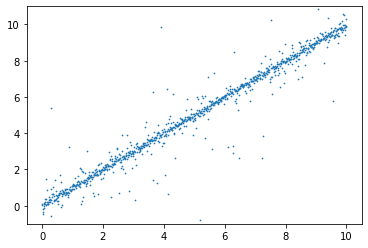

In [22]:
point_num: int = 1000

errors = np.random.standard_cauchy(point_num)
x = np.linspace(0, 10, point_num)
y = x + errors / 10

points = np.vstack([x, y]).T

plt.scatter(x, y, s=0.5)
plt.ylim(-1, 11)
plt.show()

In [23]:
linear_estimator = RANSAC(linear_basis, target_prob=0.9999)
params, inlier_bools = linear_estimator.execute(points, distance_th=0.1)

print(f"params={params}")
print(f"inlier_ratio={np.sum(inlier_bools)/points.shape[0]}")

100%|██████████| 8/8 [00:01<00:00,  7.78it/s]

params=[ 0.6979505  -0.70475072 -0.12724591]
inlier_ratio=0.811


結果をプロット

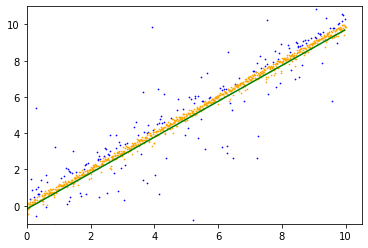

In [24]:
inlier_idx = np.arange(point_num)[inlier_bools]
outlier_idx = np.arange(point_num)[~inlier_bools]

plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")
plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")

plt.contour(*get_contour(linear_basis, points, params, 0.01), [0], colors="green")
plt.ylim(-1, 11)
plt.show()

### 2次曲線のフィッティング

サンプルデータ生成


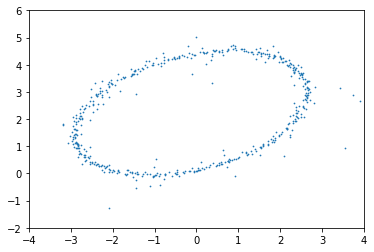

In [31]:
# データ中心
center = np.array([1, 2])
# 回転角
rad = np.deg2rad(-30)

# 点数
point_num = 500
# 誤差
errors = 0.03 * np.random.standard_cauchy((point_num, 2))
# 媒介変数
theta = np.linspace(0, 2*np.pi, point_num)
x = center[0] + 3*np.cos(theta) + errors[:, 0]
y = center[1] + 2*np.sin(theta) + errors[:, 1]

points = np.vstack([x, y]).T
# 回転行列
rot_mat = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
points = points @ rot_mat

plt.scatter(points[:, 0], points[:, 1], s=0.5)
plt.xlim(-4, 4)
plt.ylim(-2, 6)
plt.show()

In [34]:
quad_estimator = RANSAC(quad_basis, target_prob=0.9999)
params, inlier_bools = quad_estimator.execute(points, distance_th=0.03)

print(f"params={params}")
print(f"inlier_ratio={np.sum(inlier_bools)/points.shape[0]}")

100%|██████████| 2740/2740 [07:58<00:00,  5.72it/s]

params=[ 0.41925575 -0.13176228  0.04609286  0.34927692 -0.82622748 -0.00962013]
inlier_ratio=0.32


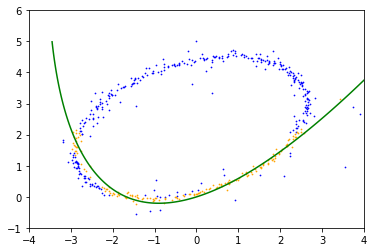

In [35]:
inlier_idx = np.arange(point_num)[inlier_bools]
outlier_idx = np.arange(point_num)[~inlier_bools]

plt.scatter(points[outlier_idx, 0], points[outlier_idx, 1], s=0.5, color="blue")
plt.scatter(points[inlier_idx, 0], points[inlier_idx, 1], s=0.5, color="orange")

plt.contour(*get_contour(quad_basis, points, params, 0.01), [0], colors="green")
plt.xlim(-4, 4)
plt.ylim(-1, 6)
plt.show()